In [1]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from skopt import gbrt_minimize
from skopt.plots import plot_evaluations, plot_objective

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(777)

In [2]:
def load_data(filename, time_step=0.1):
    df = pd.read_csv(filename, dtype=np.float64)
    t = np.cumsum(np.ones((df.shape[0],))*time_step) - time_step
    left = df.left[0] - df.left
    right = df.right[0] - df.right
    return t, left, right, df.kappa

In [3]:
def find_data():
    for root, dirs, files in os.walk("./data/"):
        for basename in files:
            if fnmatch.fnmatch(basename, "*.csv"):
                yield os.path.join(root, basename)

Given is the following transfer function:

$$
    H(s) = \frac{K}{s (T s + 1)}
$$

Its step response in time domain is given by

$$
    g(t) = K T (e^{-\frac{1}{T} t} - 1) + K t
$$

In [4]:
def exact_step_response(K, T):
    return lambda t: K*T*(np.exp(-t/T) - 1.0) + K*t

In [5]:
def simple_cost(t, y, kappa, K, T):
    model = K*T*(np.exp(-t/T) - 1.0) + K*t
    sq_e = np.square(y - model*kappa)
    return np.sqrt(np.mean(sq_e))

In [6]:
def cost_fun(x):
    cost = 0.0
    for filename in find_data():
        t, l, r, kappa = load_data(filename)
        cost += simple_cost(t, l, kappa, x[0], x[1])
        cost += simple_cost(t, r, kappa, x[0], x[1])
    return cost

In [7]:
%%time

res = gbrt_minimize(
    cost_fun,
    [(1.1, 2.2), (0.1, 2.0)],
    n_calls=500,
    )

CPU times: user 49.7 s, sys: 132 ms, total: 49.9 s
Wall time: 50.3 s


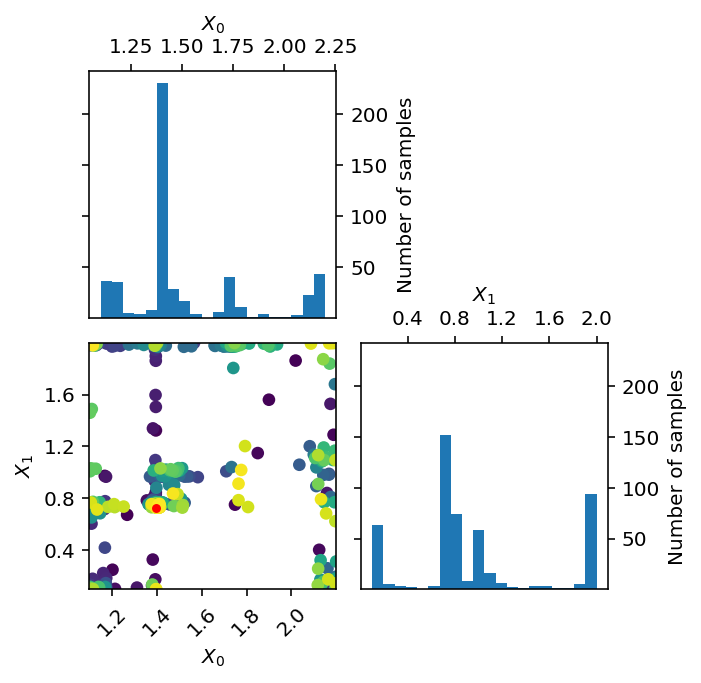

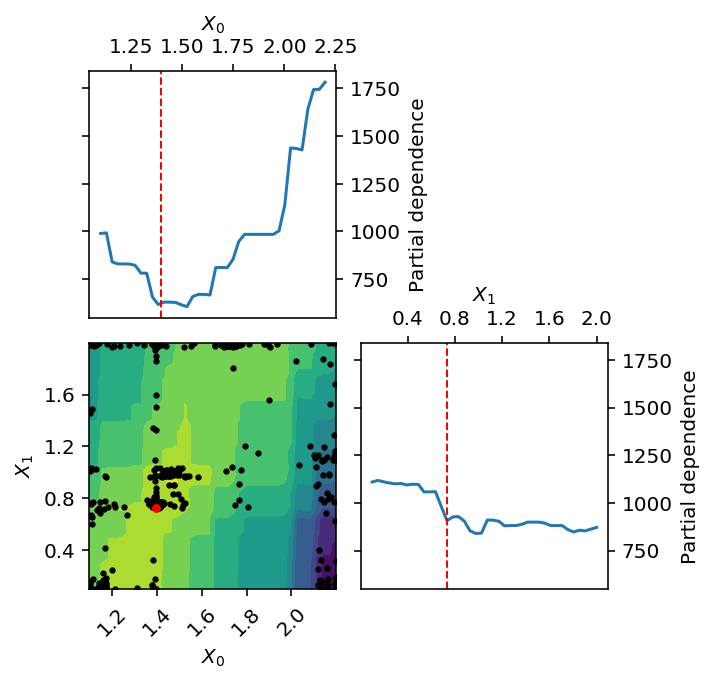

In [8]:
_ = plot_evaluations(res)
_ = plot_objective(res)

In [9]:
res.x

[1.3972350229784563, 0.73024732947069626]

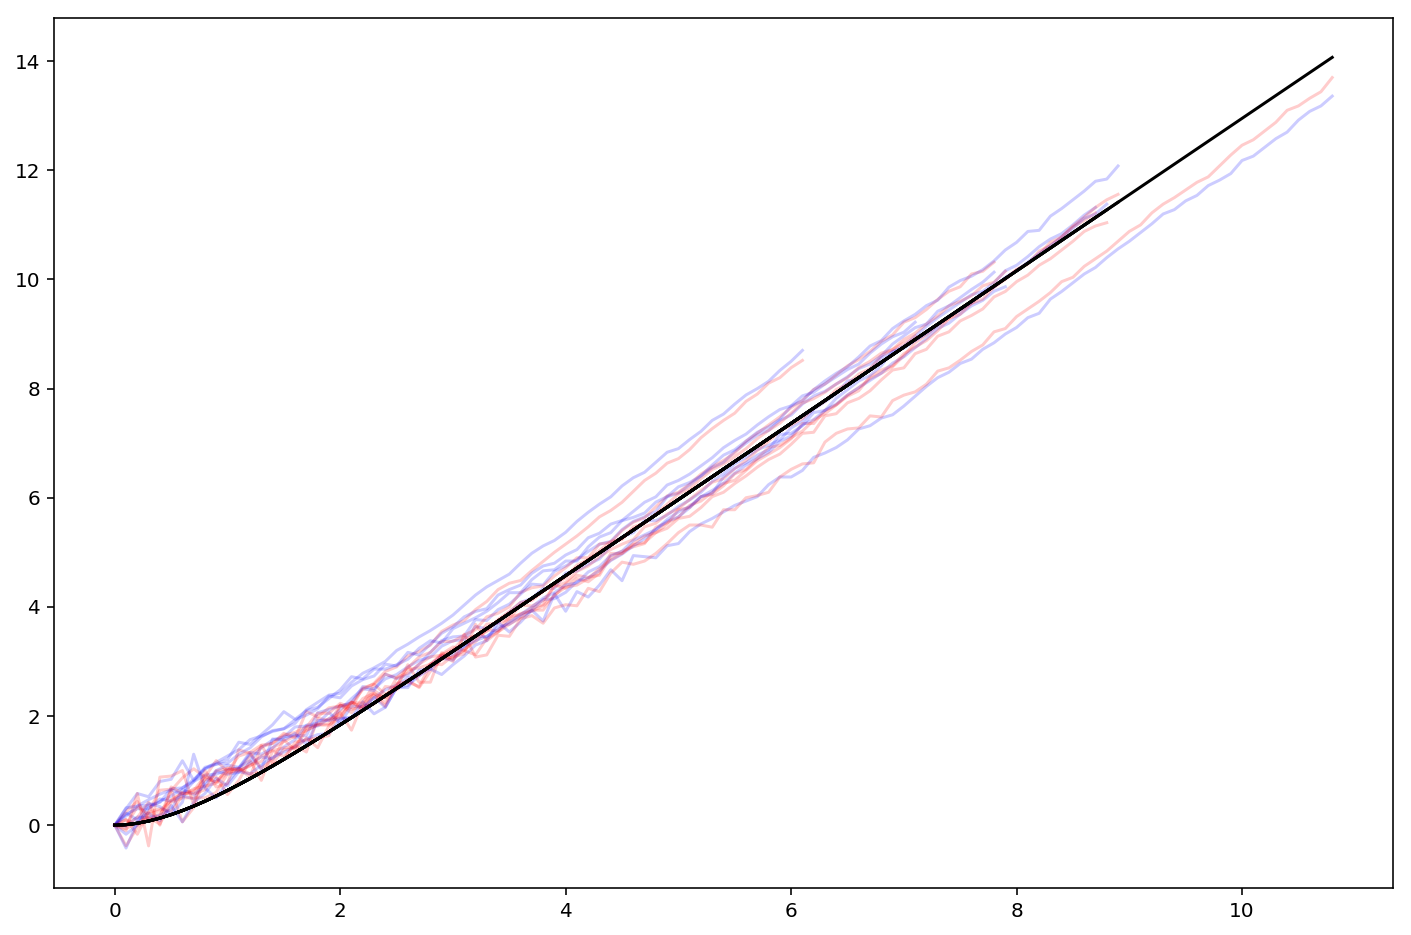

In [10]:
mdl_fun = exact_step_response(res.x[0], res.x[1])

plt.figure(figsize=(12, 8))
for filename in find_data():
    t, l, r, kappa = load_data(filename)
    plt.plot(t, l/kappa, c="b", alpha=0.2)
    plt.plot(t, r/kappa, c="r", alpha=0.2)
    plt.plot(t, mdl_fun(t), c="k")
    
plt.show()